In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.transforms.functional as F
import timm
import pandas as pd

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '/home/hannan/machineLearning/Dataset/BDD/dataset/dataset/augmented-512x512/train-augment-dataset/'


In [ ]:
# Model name
model_name = "vit_base_patch16_224"

In [ ]:
# Number of classes
num_classes = 7
 
# Batch size
batch_size = 16
 
# Number of epochs
num_epochs = 200
 
# Flag for feature extracting
feature_extract = False

In [ ]:

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 

In [ ]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
 

## train

In [ ]:
# Initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "vit_base_patch16_224":
        model_ft = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained, num_classes=num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

In [ ]:
# Set parameter requires grad
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
set_parameter_requires_grad(model_ft, feature_extract)

In [ ]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    checkpoint_path = "checkpoint.pt"

    # -------- LOAD CHECKPOINT IF EXISTS --------
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("🔄 Found checkpoint! Loading...")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        best_acc = checkpoint["best_acc"]
        start_epoch = checkpoint["epoch"] + 1

        print(f"➡ Resuming from epoch {start_epoch}, Best Acc = {best_acc:.4f}")
    else:
        print("⚠ No checkpoint found. Starting fresh.")


    # --------------- TRAIN LOOP ---------------
    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "best_model.pt")
                print("🏆 New best model saved!")

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        # -------- SAVE CHECKPOINT EVERY EPOCH --------
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "best_acc": best_acc
        }, checkpoint_path)

        print(f"💾 Checkpoint saved at epoch {epoch}")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
# # Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

In [ ]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'nn-vt-org-weights.pth')


In [ ]:
torch.load('nn-vt-org-weights.pth')

In [79]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

In [80]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)
 
    plt.figure(figsize=(14, 5))
 
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
 
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
 
plt.show()

ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

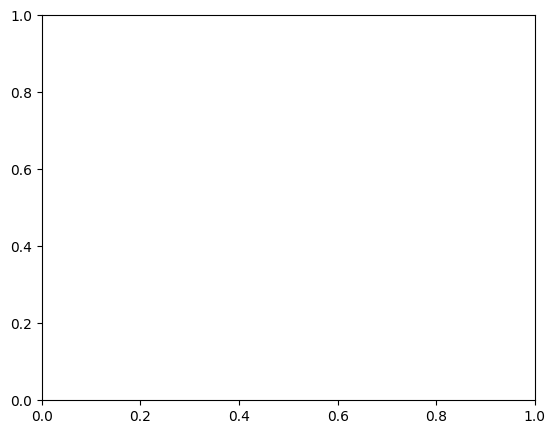

In [81]:
# Call the plot function
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)
 

## eval

In [ ]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 

In [ ]:
class_names

In [ ]:
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

In [ ]:
# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('cura_vt_results.csv', index=False)

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('curat_vt_confusion_matrix.png')
plt.show()


In [ ]:

# Function to visualize predictions
def visualize_predictions(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                plt.imshow(F.to_pil_image(inputs.cpu().data[j]))
 
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
 
# Visualize predictions
visualize_predictions(model_ft, dataloaders, class_names, num_images=6)

In [ ]:
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
 
# Ensure the confusion matrix and the classification report are saved
with open('curat_vt_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)


In [ ]:
model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))

In [ ]:
print(inputs.device) 

In [ ]:
# Load the model
model_ft.eval()
model_ft.to(device)
# Create the attention folder if it doesn't exist
attention_dir = os.path.join(data_dir, 'attention')
os.makedirs(attention_dir, exist_ok=True)

# Iterate through the test dataset
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    outputs = model_ft(inputs)

    # Get the attention map
    attention_map = model_ft.get_attention_map(inputs)

    # Save the attention map
    for i, img in enumerate(inputs):
        attention_img = F.to_pil_image(attention_map[i])
        attention_img.save(os.path.join(attention_dir, f'test_image_{i}.png'))
